# Autumn scores with segments #

In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from lightgbm.sklearn import LGBMRanker
from experiment_template import *
import os as os

In [135]:
path = "../Data/"
testing = False
print(os.getcwd())
transactions_train = pd.read_parquet(path + 'transactions_train.parquet')
customers = pd.read_parquet(path + 'customers.parquet')
articles = pd.read_parquet(path + 'articles.parquet')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

C:\Users\Arno\Documents\GitHub\ai-project-23-24\ArnoDeKeersmaeker\Research


In [136]:
transactions_train.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week
25784,2018-09-20,1728846800780188,519773001,0.028458,2,0
25785,2018-09-20,1728846800780188,578472001,0.032525,2,0
5389,2018-09-20,2076973761519164,661795002,0.167797,2,0
5390,2018-09-20,2076973761519164,684080003,0.101678,2,0
47429,2018-09-20,2918879973994241,662980001,0.033881,1,0


## Grouping transactions into seasons ##
Seasons can be defined below. The current season is the season that is used for comparing trends with the other seasons.

In [137]:
# Define periods here
seasons = {
    "Summer": [6,7,8],
    "Autumn": [9,10,11],
    "Winter": [12,1,2],
    "Spring": [3,4,5]
}
# Define the name of the current period (end of September)
current_season = "Autumn"

##### SANITY CHECKS #####
assert current_season in seasons.keys() # Current period exists
assert set(month_nr for month_nrs in seasons.values() for month_nr in month_nrs) == set(range(1,13)) # Valid month numbers
assert len([month_nr for month_nrs in seasons.values() for month_nr in month_nrs]) == 12 # Exactly 12 months
#########################

inverted = {month_nr: period for period, month_nrs in seasons.items() for month_nr in month_nrs} # For more efficient lookup

def get_season(month_nr):
    assert month_nr in range(1,13) # dataset check
    return inverted[month_nr]

transactions_train["t_dat"] = pd.to_datetime(transactions_train["t_dat"])
transactions_train["season"] = transactions_train["t_dat"].dt.month.apply(get_season) # month number to season name

In [138]:
transactions_train.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,season
25784,2018-09-20,1728846800780188,519773001,0.028458,2,0,Autumn
25785,2018-09-20,1728846800780188,578472001,0.032525,2,0,Autumn
5389,2018-09-20,2076973761519164,661795002,0.167797,2,0,Autumn
5390,2018-09-20,2076973761519164,684080003,0.101678,2,0,Autumn
47429,2018-09-20,2918879973994241,662980001,0.033881,1,0,Autumn


## Grouping customers into segments ##
Trends are different for people in different segments (age group etc). Therefore, we need group customers into segments.
Segments will have entirely separated score calculations.

In [139]:
# Prepare the customers dataframe for segmentation

average_age = int(customers[customers['age'] != -1]['age'].mean()) # do not include -1 for average age
customers['age'] = customers['age'].replace(-1, int(average_age))


##### SANITY CHECKS #####
assert all(customers['age'] != -1) # no more -1 values
assert not customers["age"].hasnans
#########################

customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,-1,-1,0,0,49,6305
1,11246327431398957306,-1,-1,0,0,25,33726
2,18439897732908966680,-1,-1,0,0,24,3247
3,18352672461570950206,-1,-1,0,0,54,168643
4,18162778555210377306,1,1,0,1,52,168645
...,...,...,...,...,...,...,...
1371975,7551062398649767985,-1,-1,0,0,24,50351
1371976,9305341941720086711,-1,-1,0,0,21,80169
1371977,10160427316885688932,1,1,0,1,21,106737
1371978,2551401172826382186,1,1,0,1,18,111894


In [140]:
# segment definition   column_name -> dict {column_value -> segment_name}
segments = {
    # "age" : {float(age): "young" if age < 35 else "middle" for age in range(0,120)},
    # "FN" : {1.0 : "yes_FN", -1.0: "no_FN"},
    "age" : {float(age): "age_young" for age in range(0,120)}
}

segmented_customers = customers.copy()
segment_names = set()

def assign_segment(row):
    # Decide the segment for a single customer
    segment_name = [segments[column][row[column]] for column in segments] # find label for each column
    segment_name = "/".join(segment_name) # composite segment name eg "age_young/yes_FN"
    segment_names.add(segment_name)
    return segment_name

# Apply to every customer
segmented_customers['segment'] = segmented_customers.apply(assign_segment, axis=1)

segment_names = list(segment_names)
print(f"Customer segments: {segment_names}")

##### SANITY CHECKS #####
for column in segments.keys(): assert column in customers.columns # columns that determine segments need to exist
assert len(segmented_customers) == len(customers) # divides all customers into segments
assert all(segment_name not in customers.columns for segment_name in segment_names) # segment names will be added as columns so need to be new
assert all(segment_name not in articles.columns for segment_name in segment_names)
assert all(segment_name not in transactions_train.columns for segment_name in segment_names)
#########################

segmented_customers

Customer segments: ['age_young']


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,segment
0,6883939031699146327,-1,-1,0,0,49,6305,age_young
1,11246327431398957306,-1,-1,0,0,25,33726,age_young
2,18439897732908966680,-1,-1,0,0,24,3247,age_young
3,18352672461570950206,-1,-1,0,0,54,168643,age_young
4,18162778555210377306,1,1,0,1,52,168645,age_young
...,...,...,...,...,...,...,...,...
1371975,7551062398649767985,-1,-1,0,0,24,50351,age_young
1371976,9305341941720086711,-1,-1,0,0,21,80169,age_young
1371977,10160427316885688932,1,1,0,1,21,106737,age_young
1371978,2551401172826382186,1,1,0,1,18,111894,age_young


In [141]:
# Other attributes become irrelevant after determining the segment
segmented_customers = segmented_customers[['customer_id', 'segment']]

# Add segment to transactions, so we can split them up later
transactions = pd.merge(transactions_train, segmented_customers, on="customer_id") # add segment to customers
assert len(transactions) == len(transactions_train)

In [142]:
# split the transactions: segment_name -> transactions
transactions_per_segment = {}


for segment_name in segment_names:
    transactions_per_segment[segment_name] = transactions[transactions['segment'] == segment_name]

## Initial visualizations ##
To check whether the segments and seasons make sense

In [143]:
def pie_plot(data_column, title):
    counts = data_column.value_counts()
    assert counts.sum() == len(data_column)
    
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(title)
    plt.show()

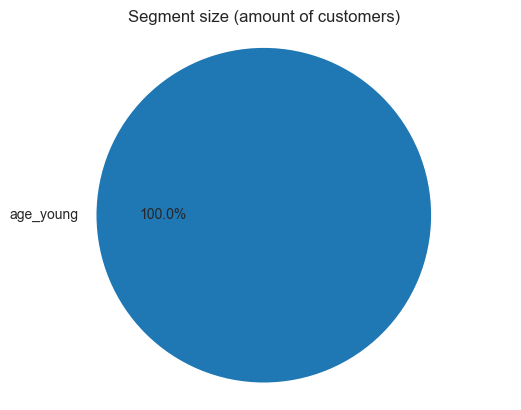

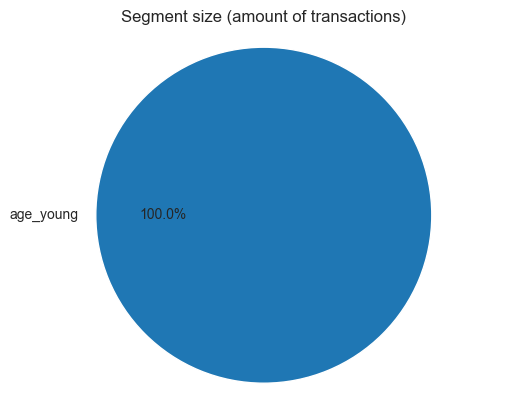

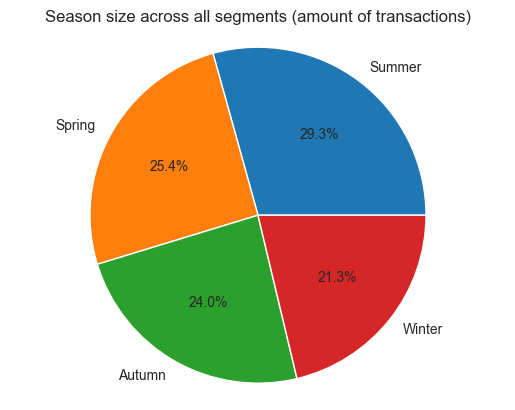

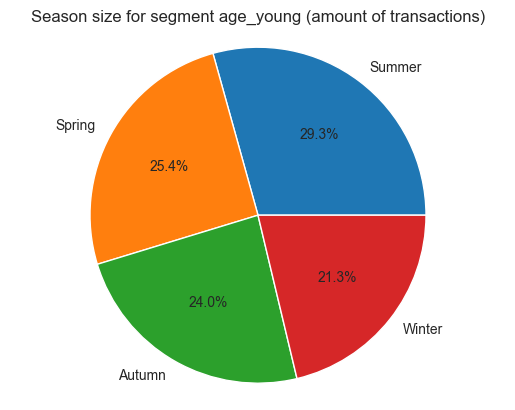

In [144]:
#Visualize segment sizes
pie_plot(segmented_customers['segment'], "Segment size (amount of customers)")
pie_plot(transactions['segment'], "Segment size (amount of transactions)")
pie_plot(transactions['season'], "Season size across all segments (amount of transactions)")
for segment_name in segment_names:
    pie_plot(transactions_per_segment[segment_name]['season'], f"Season size for segment {segment_name} (amount of transactions)")

## Calculating feature scores ##
Use increases or decreases in sales of articles with a specific feature (eg. color=blue) of a season compared to all seasons to calculate a score for that feature.

In [145]:
# Each segment has an entry in the transactions_per_segment dictionary
next(iter(transactions_per_segment.values()))

,t_dat,customer_id,article_id,price,sales_channel_id,week,season,segment
0,2018-09-20,1728846800780188,519773001,0.028458,2,0,Autumn,age_young
1,2018-09-20,1728846800780188,578472001,0.032525,2,0,Autumn,age_young
2,2018-10-05,1728846800780188,533518001,0.047441,2,2,Autumn,age_young
3,2018-10-05,1728846800780188,569981006,0.020322,2,2,Autumn,age_young
4,2018-10-05,1728846800780188,669393001,0.067797,2,2,Autumn,age_young
...,...,...,...,...,...,...,...,...
31788319,2020-09-22,18409112236320621348,621381014,0.033881,2,104,Autumn,age_young
31788320,2020-09-22,18417769707947924979,729860001,0.022017,2,104,Autumn,age_young
31788321,2020-09-22,18417769707947924979,889747001,0.022017,2,104,Autumn,age_young
31788322,2020-09-22,18417769707947924979,778517001,0.022017,2,104,Autumn,age_young


In [146]:
# (segment_name, feature_name) -> {feature_value -> score}
# eg: for people under 35, the score of a blue article is 1.2
all_scores = {} 

# features to use for calculating seasonal score
features = ["product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]

In [147]:
# # As seen in the visualizations above, the amount of transactions differs per season
# # Therefore, we can't just absolutely count the amount of transactions per feature
# 
# 
# # for each segment, find the relative size of the current season compared to all seasons
# relative_size_per_segment = {}
# 
# # calculated fully separated based on segment
# for segment_name, segment in transactions_per_segment.items():
#     current_period_size = len(segment[segment['season'] == current_season]) # amount of transactions in current season
#     all_periods_size = len(segment) # amount of transactions in all seasons
#     relative_size_per_segment[segment_name] = current_period_size / all_periods_size
# 
# relative_size_per_segment


# # for each segment, calculate all scores separately
# for segment_name, segment_transactions in transactions_per_segment.items():
#     print(f"Current segment: {segment_name}")
#     segment_transactions = pd.merge(segment_transactions, articles, on="article_id")
# 
#     # find the ratio for each feature
#     for feature in features:
#         seasonal_sales_by_type = segment_transactions.groupby(["season", feature])["article_id"].size().reset_index(name="count")
#         assert seasonal_sales_by_type["count"].sum() == len(segment_transactions)
#         relative_season_size = 1 / relative_size_per_segment[segment_name] # relative size of the current season compared to all seasons
# 
#         # Calculate the average sales over all seasons for each feature type (eg average sales of an article that's blue)
#         type_average_sales = seasonal_sales_by_type.groupby([feature])["count"].sum().div(relative_season_size).reset_index(name = "avg_all_seasons")
# 
#         # Only current season is relevant from now on
#         seasonal_sales_by_type = seasonal_sales_by_type[seasonal_sales_by_type["season"] == current_season]
#         seasonal_sales_by_type = seasonal_sales_by_type.merge(type_average_sales, on=feature)
#         seasonal_sales_by_type["season_ratio"] = seasonal_sales_by_type["count"] / seasonal_sales_by_type["avg_all_seasons"]
# 
#         # # Only keeping the 75% most sold combinations
#         # threshold = seasonal_sales_by_type["count"].quantile(0.25)
#         # seasonal_sales_by_type = seasonal_sales_by_type[seasonal_sales_by_type["count"] > threshold]
# 
#         # Creating a ratio look up table
#         seasonal_sales_by_type = seasonal_sales_by_type[[feature, "season_ratio"]]
#         seasonal_sales_by_type = seasonal_sales_by_type.rename(columns = {feature: "feature"})
# 
#         # Save together with the other segments
#         all_scores[(segment_name, feature)] = seasonal_sales_by_type.set_index("feature").to_dict()["season_ratio"]
# print("Done")

In [148]:
# Less confusing implementation with the same result
# For each feature and each segment
# STEP 1. Calculating the ratio of purchases of a feature (eg. color blue) in the current season
# STEP 2. Calculating the ratio of purchases of a feature (eg. color blue) in all seasons
# STEP 3. Taking the ratio of the two ratios -> how much more popular is the feature in the current season compared to all seasons

# for each segment, calculate all scores separately
for segment_name, segment_transactions in transactions_per_segment.items():
    print(f"Current segment: {segment_name}")
    segment_transactions = pd.merge(segment_transactions, articles, on="article_id")
    current_season_transactions = segment_transactions[segment_transactions["season"] == current_season] # only relevant season

    # find the ratio for each feature
    for feature in features:
        # STEP 1
        # For each possible value of the feature, check how many times it was sold in the current season
        current_season_ratio = current_season_transactions.groupby([feature])["article_id"].size().reset_index(name="count")
        
        # Then calculate the ratio of that feature value compared to all purchases in the current season
        current_season_ratio["current_season_ratio"] = current_season_ratio["count"] / current_season_ratio["count"].sum()
        current_season_ratio = current_season_ratio[[feature, "current_season_ratio"]] # keep relevant columns
        
        
        # STEP 2
        # Same as step 1, but for all seasons
        all_seasons_ratio = segment_transactions
        all_seasons_ratio = all_seasons_ratio.groupby([feature])["article_id"].size().reset_index(name="count")
        all_seasons_ratio["all_seasons_ratio"] = all_seasons_ratio["count"] / all_seasons_ratio["count"].sum()
        all_seasons_ratio = all_seasons_ratio[[feature, "all_seasons_ratio"]]
        
        # STEP 3
        # Merge the two tables and calculate the ratio of the two ratios
        score = pd.merge(current_season_ratio, all_seasons_ratio, on=feature) 
        score["season_ratio"] = score["current_season_ratio"] / score["all_seasons_ratio"]
        score = score[[feature, "season_ratio"]]
        score = score.rename(columns = {feature: "feature"})


        ##### SANITY CHECKS #####
        assert len(score) == len(current_season_transactions[feature].unique()) # every feature value that occurs in the current season gets a score
        assert score["season_ratio"].min() >= 0
        #########################
        

        # Save together with the other segments
        all_scores[(segment_name, feature)] = score.set_index("feature").to_dict()["season_ratio"]
# print("Done")

Current segment: age_young


In [149]:
# all_scores[("age_young", "product_type_name")]

## Calculating article scores ##
Use the feature scores to calculate a score for each article.

In [150]:
# Calculate the season compatibility scores for each article
# The score of an article is the sum of the scores of its features

def create_article_scores(article):
    result = [0 for _ in range(len(segment_names))] # all counters start at 0
    
    # feature by feature, segment by segment
    for feature in features:
        feature_value = article[feature] # the feature value of the article (e.g. color blue)
        for i, segment_name in enumerate(segment_names):
            score_table = all_scores[(segment_name, feature)] # table that gives the feature score of a segment
            if not feature_value in score_table:
                continue
            result[i] += score_table[feature_value] # sum (better than multiplication)
            
    ##### SANITY CHECKS #####
    assert len(result) == len(segment_names) # one score for each segment
    assert all(res >= 0 for res in result)
    #########################
    
    return pd.Series(result)

In [151]:
articles_scores = pd.DataFrame(articles["article_id"]) # create a dataframe with only the article id

# Create a column for each segment, containing the score of the article for that segment
articles_scores[segment_names] = articles.apply(create_article_scores, axis=1, result_type="expand")

# Normalize the scores for each segment
for segment_name in segment_names:
    articles_scores[segment_name] = MinMaxScaler().fit_transform(articles_scores[[segment_name]])

##### SANITY CHECKS #####
assert len(articles_scores) == len(articles)
assert all(0 <= score <= 1 for score in articles_scores[segment_names].values.flatten()) # scores are normalized
#########################

articles_scores.head()

,article_id,age_young
0,108775015,0.423286
1,108775044,0.330456
2,108775051,0.338925
3,110065001,0.364676
4,110065002,0.271845


In [152]:
articles_scores.to_parquet(path + 'articles_edited2.parquet')

## Customer sensitivity ##
Use historical transactions of customers to calculate how sensitive they are to the trends of the current season.

In [153]:
# Get customers + articles pairs for the current season
transactions_current_season = transactions_train[transactions_train["season"] == current_season]
transactions_current_season = transactions_current_season[["customer_id", "article_id"]]

# Also add article scores and customer segments
transactions_scores_segments = pd.merge(transactions_current_season, articles_scores, on="article_id", how="left")
transactions_scores_segments = pd.merge(transactions_scores_segments, segmented_customers, on="customer_id", how="left")

##### SANITY CHECKS #####
assert len(transactions_scores_segments) == len(transactions_current_season) # people who bought something in the current season get a score
assert all(segment_name in transactions_scores_segments.columns for segment_name in segment_names) # segment columns are needed
#########################


transactions_scores_segments.head()

,customer_id,article_id,age_young,segment
0,1728846800780188,519773001,0.742832,age_young
1,1728846800780188,578472001,0.640314,age_young
2,2076973761519164,661795002,0.647760,age_young
3,2076973761519164,684080003,0.669953,age_young
4,2918879973994241,662980001,0.770488,age_young


In [154]:
# Article scores differ per segment, so we need to select the applicable score for each transaction depending on the segment of the customer
# Code following the principle here: https://pandas.pydata.org/pandas-docs/version/1.3/user_guide/indexing.html#indexing-lookup

idx, cols = pd.factorize(transactions_scores_segments['segment'])
result = transactions_scores_segments.reindex(cols, axis=1).to_numpy()[np.arange(len(transactions_scores_segments)), idx]


##### SANITY CHECKS #####
assert len(result) == len(transactions_scores_segments)
if testing: # takes more time so only enable for testing
    
    # For testing purposes: less efficient but more clear implementation should have the same result
    def get_applicable_score(row):
        return row[row["segment"]] # Take the value of the corresponding segment column

    test_result = transactions_scores_segments.apply(get_applicable_score, axis=1).values
    assert np.array_equal(result, test_result)
#########################

# Add the applicable score as a new column
transactions_scores_segments["article_score"] = result

transactions_scores_segments.head() # Now the right score should always be in the score column

,customer_id,article_id,age_young,segment,article_score
0,1728846800780188,519773001,0.742832,age_young,0.742832
1,1728846800780188,578472001,0.640314,age_young,0.640314
2,2076973761519164,661795002,0.647760,age_young,0.647760
3,2076973761519164,684080003,0.669953,age_young,0.669953
4,2918879973994241,662980001,0.770488,age_young,0.770488


In [155]:
# drop all non-applicable columns and segment
transactions_scores_segments.drop(columns=segment_names + ["segment"], inplace=True)
transactions_scores_segments.head()

,customer_id,article_id,article_score
0,1728846800780188,519773001,0.742832
1,1728846800780188,578472001,0.640314
2,2076973761519164,661795002,0.647760
3,2076973761519164,684080003,0.669953
4,2918879973994241,662980001,0.770488


In [156]:
# Per customer, calculate the average score of the articles they bought
customer_sensitivity = transactions_scores_segments.groupby(["customer_id"])["article_score"].mean().reset_index()
customer_sensitivity = customer_sensitivity.rename(columns={"article_score": "sensitivity"})

##### SANITY CHECKS #####
assert len(customer_sensitivity) == len(transactions_scores_segments["customer_id"].unique())
assert all(0 <= score <= 1 for score in customer_sensitivity["sensitivity"])
#########################

customer_sensitivity

,customer_id,sensitivity
0,25398598941468,0.533632
1,28847241659200,0.521105
2,41318098387474,0.570600
3,43757848922470,0.435964
4,77117344919861,0.555510
...,...,...
803361,18446590778427270109,0.488886
803362,18446630855572834764,0.517238
803363,18446705133201055310,0.699461
803364,18446723086055369602,0.682576


In [157]:
# Add new feature to customers table
customers = pd.merge(customers, customer_sensitivity, on="customer_id", how="left")
customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,sensitivity
0,6883939031699146327,-1,-1,0,0,49,6305,0.561674
1,11246327431398957306,-1,-1,0,0,25,33726,0.532233
2,18439897732908966680,-1,-1,0,0,24,3247,0.424149
3,18352672461570950206,-1,-1,0,0,54,168643,NaN
4,18162778555210377306,1,1,0,1,52,168645,0.610074
...,...,...,...,...,...,...,...,...
1371975,7551062398649767985,-1,-1,0,0,24,50351,0.440379
1371976,9305341941720086711,-1,-1,0,0,21,80169,0.447840
1371977,10160427316885688932,1,1,0,1,21,106737,0.509370
1371978,2551401172826382186,1,1,0,1,18,111894,NaN


In [158]:
# Customers who didn't buy anything in the current season have no data
# Fill their sensitivity with the average sensitivity

average = customers["sensitivity"].mean()
customers["sensitivity"].fillna(average, inplace=True)
customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,sensitivity
0,6883939031699146327,-1,-1,0,0,49,6305,0.561674
1,11246327431398957306,-1,-1,0,0,25,33726,0.532233
2,18439897732908966680,-1,-1,0,0,24,3247,0.424149
3,18352672461570950206,-1,-1,0,0,54,168643,0.505463
4,18162778555210377306,1,1,0,1,52,168645,0.610074
...,...,...,...,...,...,...,...,...
1371975,7551062398649767985,-1,-1,0,0,24,50351,0.440379
1371976,9305341941720086711,-1,-1,0,0,21,80169,0.447840
1371977,10160427316885688932,1,1,0,1,21,106737,0.509370
1371978,2551401172826382186,1,1,0,1,18,111894,0.505463


## Prepare for training ##
Below is an adapted version of Noah's template version of Radek's code.

In [159]:
columns_to_use = [
    'article_id',
    'product_type_no',
    'graphical_appearance_no',
    'colour_group_code',
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_code',
    'index_group_no',
    'section_no',
    'garment_group_no',
    'FN',
    'Active',
    'club_member_status',
    'fashion_news_frequency',
    'age',
    'postal_code',
    'ranked_weighted_sales',
]
def add_features(data):
    result = data
    result = pd.merge(result, customers, how='left', on='customer_id')
    result = pd.merge(result, articles, how='left', on='article_id')

    # features from assignment 2 could go here
    # customer_avg_price = transactions_train.groupby('customer_id')['price'].mean().to_frame('preferred_price')
    # result = pd.merge(result, customer_avg_price, how="left", on="customer_id")

    return result[columns_to_use]

In [160]:
def recall(predictions, purchases, k=12):
    # number of correct predictions for the customer / items bought by the customer
    # total recall is the average recall over all customers

    def row_recall(row):
        assert 0 < len(row.purchases)
        correct = 0
        for predicted_item in row.prediction[:k]:
            if predicted_item in row.purchases:
                correct += 1
        return correct / min(len(row.purchases), 12)

    result = pd.merge(purchases, predictions, on="customer_id", how="inner")
    result["recall"] = result.apply(row_recall, axis=1)

    return result.recall.sum() / len(purchases)

In [161]:
segmented_customers

,customer_id,segment
0,6883939031699146327,age_young
1,11246327431398957306,age_young
2,18439897732908966680,age_young
3,18352672461570950206,age_young
4,18162778555210377306,age_young
...,...,...
1371975,7551062398649767985,age_young
1371976,9305341941720086711,age_young
1371977,10160427316885688932,age_young
1371978,2551401172826382186,age_young


In [162]:
### split into training and testing
# one week is used for testing
# a number of weeks leading up to the test week are used to train the ranker
test_week = 105
num_training_weeks = 10
training_weeks = np.arange(test_week-num_training_weeks, test_week)
train_data = transactions_train[transactions_train.week.isin(training_weeks)].reset_index(drop=True)

# add segment of the customer to each transaction
train_data = train_data.merge(segmented_customers, on="customer_id")
train_data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,season,segment
0,2020-07-15,272412481300040,778064028,0.008458,1,95,Summer,age_young
1,2020-07-15,272412481300040,816592008,0.016932,1,95,Summer,age_young
2,2020-07-15,272412481300040,621381021,0.033881,1,95,Summer,age_young
3,2020-07-15,272412481300040,817477003,0.025407,1,95,Summer,age_young
4,2020-07-15,272412481300040,899088002,0.025407,1,95,Summer,age_young


In [163]:
articles_scores.head()

,article_id,age_young
0,108775015,0.423286
1,108775044,0.330456
2,108775051,0.338925
3,110065001,0.364676
4,110065002,0.271845


In [164]:
### repurchase
# each week is seen as a basket
# the items bought in one basket, will be example for the next basket
# the items bought in the last basket, will be candidates for the test basket
c2weeks = train_data.groupby('customer_id')['week'].unique()
c2weeks2shifted_weeks = {}
for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}
    for i in range(weeks.shape[0]-1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week
candidates_last_purchase = train_data.copy()
weeks = []
for i, (c_id, week) in enumerate(zip(train_data['customer_id'], train_data['week'])):
    weeks.append(c2weeks2shifted_weeks[c_id][week])
candidates_last_purchase.week=weeks

sales_counts = train_data.groupby(["week", "article_id", "segment"]).size().reset_index(name="count")
sales_counts = sales_counts.merge(articles_scores, on="article_id")
sales_counts

,week,article_id,segment,count,age_young
0,95,108775015,age_young,2,0.423286
1,96,108775015,age_young,1,0.423286
2,95,108775044,age_young,3,0.330456
3,96,108775044,age_young,8,0.330456
4,97,108775044,age_young,6,0.330456
...,...,...,...,...,...
196875,104,944241001,age_young,35,0.492149
196876,104,945600001,age_young,12,0.610716
196877,104,946475001,age_young,1,0.471501
196878,104,946527001,age_young,4,0.391841


In [165]:
def get_applicable_score(row):
    return row[row["segment"]]
sales_counts = sales_counts.copy()
sales_counts["season_score"] = sales_counts.apply(get_applicable_score, axis=1)
sales_counts

,week,article_id,segment,count,age_young,season_score
0,95,108775015,age_young,2,0.423286,0.423286
1,96,108775015,age_young,1,0.423286,0.423286
2,95,108775044,age_young,3,0.330456,0.330456
3,96,108775044,age_young,8,0.330456,0.330456
4,97,108775044,age_young,6,0.330456,0.330456
...,...,...,...,...,...,...
196875,104,944241001,age_young,35,0.492149,0.492149
196876,104,945600001,age_young,12,0.610716,0.610716
196877,104,946475001,age_young,1,0.471501,0.471501
196878,104,946527001,age_young,4,0.391841,0.391841


In [166]:
sales_counts = sales_counts.drop(columns=segment_names)
sales_counts

,week,article_id,segment,count,season_score
0,95,108775015,age_young,2,0.423286
1,96,108775015,age_young,1,0.423286
2,95,108775044,age_young,3,0.330456
3,96,108775044,age_young,8,0.330456
4,97,108775044,age_young,6,0.330456
...,...,...,...,...,...
196875,104,944241001,age_young,35,0.492149
196876,104,945600001,age_young,12,0.610716
196877,104,946475001,age_young,1,0.471501
196878,104,946527001,age_young,4,0.391841


In [167]:
sales_counts["weighted_sales"] = sales_counts["count"] ** sales_counts["season_score"]
sales_counts

,week,article_id,segment,count,season_score,weighted_sales
0,95,108775015,age_young,2,0.423286,1.340978
1,96,108775015,age_young,1,0.423286,1.000000
2,95,108775044,age_young,3,0.330456,1.437697
3,96,108775044,age_young,8,0.330456,1.988068
4,97,108775044,age_young,6,0.330456,1.807775
...,...,...,...,...,...,...
196875,104,944241001,age_young,35,0.492149,5.753229
196876,104,945600001,age_young,12,0.610716,4.561136
196877,104,946475001,age_young,1,0.471501,1.000000
196878,104,946527001,age_young,4,0.391841,1.721520


In [168]:
sales_counts["ranked_weighted_sales"] = (sales_counts.groupby("week")["weighted_sales"].rank(method="dense", ascending=False).astype("int64"))
sales_counts

,week,article_id,segment,count,season_score,weighted_sales,ranked_weighted_sales
0,95,108775015,age_young,2,0.423286,1.340978,12431
1,96,108775015,age_young,1,0.423286,1.000000,14203
2,95,108775044,age_young,3,0.330456,1.437697,11561
3,96,108775044,age_young,8,0.330456,1.988068,8286
4,97,108775044,age_young,6,0.330456,1.807775,9194
...,...,...,...,...,...,...,...
196875,104,944241001,age_young,35,0.492149,5.753229,1450
196876,104,945600001,age_young,12,0.610716,4.561136,2098
196877,104,946475001,age_young,1,0.471501,1.000000,11249
196878,104,946527001,age_young,4,0.391841,1.721520,7743


In [169]:
sales_counts = sales_counts[sales_counts["ranked_weighted_sales"] <= 12]
sales_counts.week += 1
sales_counts = sales_counts.sort_values(by=["week", "article_id", "segment"])

# A list of all customers that bought something during each week
customers_per_week = (train_data.groupby(['week', 'customer_id', 'segment']).head(1).
                      drop(columns=['article_id', 'price', "t_dat", "season", "sales_channel_id"]).drop_duplicates(["week","customer_id"]).copy())
candidates_bestsellers = pd.merge(customers_per_week,sales_counts,on=['week', 'segment'])
candidates_bestsellers_test_week = customers_per_week.drop_duplicates('customer_id').reset_index(drop=True) # all customers who ever bought something
candidates_bestsellers_test_week.week = test_week # join on test week
candidates_bestsellers_test_week = pd.merge(candidates_bestsellers_test_week,sales_counts,on=['week', 'segment'])
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
candidates_bestsellers.drop(columns='ranked_weighted_sales', inplace=True)

### combine
d = train_data.copy()
d['purchased'] = True

candidates = pd.concat([
    d, candidates_last_purchase, candidates_bestsellers
])

C:\Users\Arno\AppData\Local\Temp\ipykernel_4524\1642060979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_counts.week += 1


In [170]:
candidates

,t_dat,customer_id,article_id,price,sales_channel_id,week,season,segment,purchased,count,season_score,weighted_sales
0,2020-07-15,272412481300040,778064028,0.008458,1.0,95,Summer,age_young,True,NaN,NaN,NaN
1,2020-07-15,272412481300040,816592008,0.016932,1.0,95,Summer,age_young,True,NaN,NaN,NaN
2,2020-07-15,272412481300040,621381021,0.033881,1.0,95,Summer,age_young,True,NaN,NaN,NaN
3,2020-07-15,272412481300040,817477003,0.025407,1.0,95,Summer,age_young,True,NaN,NaN,NaN
4,2020-07-15,272412481300040,899088002,0.025407,1.0,95,Summer,age_young,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5248375,NaT,18438270306572912089,915529003,NaN,NaN,105,NaN,age_young,NaN,495.0,0.683502,69.465452
5248376,NaT,18438270306572912089,915529005,NaN,NaN,105,NaN,age_young,NaN,491.0,0.676226,66.035734
5248377,NaT,18438270306572912089,918525001,NaN,NaN,105,NaN,age_young,NaN,342.0,0.676226,51.709947
5248378,NaT,18438270306572912089,924243001,NaN,NaN,105,NaN,age_young,NaN,852.0,0.676226,95.860383


In [171]:
candidates.purchased.fillna(False, inplace=True)
candidates.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

candidates = pd.merge(
    candidates,
    sales_counts[['week', 'article_id', 'ranked_weighted_sales']],
    on=['week', 'article_id'],
    how='left'
)
candidates = candidates[candidates.week != candidates.week.min()]
candidates["ranked_weighted_sales"].fillna(999, inplace=True)

candidates.sort_values(['week', 'customer_id'], inplace=True)
candidates.reset_index(drop=True, inplace=True)

train_examples = candidates[candidates.week != test_week]
X_train = add_features(train_examples)
Y_train = train_examples['purchased']

ranker = LGBMRanker(
    force_row_wise=True,
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)
train_groups = train_examples.groupby(['week', 'customer_id'])['article_id'].count().values

In [172]:
X_train

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,ranked_weighted_sales
0,887770001,253,1010016,9,4,5,1510,0,1,6,1010,1,1,0,1,21,57896,999.0
1,762846001,259,1010016,10,3,9,1515,0,1,11,1010,1,1,0,1,21,57896,999.0
2,829308001,273,1010016,9,4,5,8310,9,26,5,1005,1,1,0,1,21,57896,999.0
3,372860001,302,1010016,9,4,5,3611,7,1,62,1021,1,1,0,1,21,57896,7.0
4,547780003,272,1010010,7,1,12,1643,1,2,51,1002,1,1,0,1,21,57896,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11395448,896169002,245,1010010,7,2,12,1626,0,1,15,1003,1,1,0,1,60,96323,10.0
11395449,911870003,252,1010010,15,2,1,1626,0,1,15,1003,1,1,0,1,60,96323,5.0
11395450,915529003,252,1010016,9,4,5,1626,0,1,15,1003,1,1,0,1,60,96323,6.0
11395451,918525001,252,1010016,13,1,1,1626,0,1,15,1003,1,1,0,1,60,96323,12.0


In [173]:
ranker.fit(X_train, Y_train, group=train_groups)
print_importance(ranker, X_train.columns)

### test
# candidates are generated similarly to the examples, only we don't know whether they are purchased
# the same features are extracted and added
# each candidate is scored by the ranker and predictions are generated using the highest scoring candidates
test_candidates = candidates[candidates.week == test_week]

X_test = add_features(test_candidates)
predictions = get_predictions(test_candidates, X_test, ranker, 12)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.164178
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 11395453, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
         ranked_weighted_sales 0.99899
                    article_id 0.00021
                           age 0.00021
               product_type_no 0.00011
              garment_group_no 0.00010
             colour_group_code 0.00008
            club_member_status 0.00007
                   postal_code 0.00007
                 department_no 0.00006
    perceived_colour_master_id 0.00006
                        Active 0.00002
       graphical_appearance_no 0.00001
        fashion_news_frequency 0.00000
                            FN 0.00000
                    section_no 0.00000
                    index_code 0.00000
     perceived_colour_value_id 0.00000
                index_group_no 0.00000


In [174]:
len(predictions)

437365

In [175]:
### evaluate
if test_week < transactions_train.week.max() + 1:
    # get ground truth data for test week
    purchases = get_purchases(transactions_train[transactions_train.week == test_week])

    # fill missing prediction for customers in test set with popular items in last week
    # only for customers in test set because only those are evaluated
    popular = transactions_train[transactions_train.week == test_week-1].article_id.value_counts().head(12).index.values
    predictions = fill_missing_predictions(predictions, purchases.customer_id, popular)

    # calculate score
    score = mean_average_precision(predictions, purchases, 12)
    print(score)
    score2 = recall(predictions, purchases, 12)
    print(score2)

### submit
else:
    # fill missing predictions for all customers with popular items in last week
    # all customers because we don't know which ones will be evaluated
    popular = transactions_train[transactions_train.week == test_week-1].article_id.value_counts().head(12).index.values
    predictions = fill_missing_predictions(predictions, customers.customer_id, popular)

    # write submission
    sub = create_submission(predictions, sample_submission)
    sub.to_csv(path + 'sub1.csv.gz', index=False)

In [176]:
sales_counts

,week,article_id,segment,count,season_score,weighted_sales,ranked_weighted_sales
2316,96,372860001,age_young,344,0.524160,21.358092,7
7835,96,547780003,age_young,423,0.554545,28.603742,1
11989,96,579541001,age_young,115,0.670383,24.068885,3
22733,96,678942001,age_young,172,0.623273,24.736854,2
22811,96,678942057,age_young,118,0.663542,23.701807,4
...,...,...,...,...,...,...,...
175511,105,915529003,age_young,495,0.683502,69.465452,4
190128,105,915529005,age_young,491,0.676226,66.035734,5
193407,105,918525001,age_young,342,0.676226,51.709947,11
190339,105,924243001,age_young,852,0.676226,95.860383,1
